In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime as dt
import os
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import scipy.stats as stats
import math
import random

In [2]:
# Importing the Dataset
file_names = glob.glob ('./EthernetData/dataset6.csv')
k = 0

# Change these two variables to get different results
#degree change
n = 1
#operating state
op_state = 'Heating'
exclude_state = 'Cooling'

# Given millisecond utc timestamp return time
def tz_from_utc_ms_ts(utc_ms_ts):
    
    # convert from time stamp to datetime
    utc_datetime = dt.datetime.utcfromtimestamp(utc_ms_ts / 1000.)
    
    # getting time from datetime object
    res = utc_datetime.hour + utc_datetime.minute / 60
    if res - 5 < 0:
        res = 24 + (res - 5)
    else:
        res = res - 5
    return res

# Visualising the result as time of day vs cooling time of machine
def plot (time_difference, y, temp_change):
    fig = plt.figure (k)
    ax = plt.subplot ()
    plt.bar (y, time_difference, 0.05, align = 'center', alpha = 1)
    plt.xlabel ('Time of day')
    plt.ylabel ('Time taken for ' + op_state + ' ' + str (temp_change) + ' Degree (in Minutes)')
    ax.set_xticks ([0,5,10,15,20,24])
    ax.set_xticklabels (['00:00', '05:00', '10:00', '15:00', '20:00', '00:00'])
    plt.title (os.path.basename (path))
    plt.show ()
    pp.savefig (fig)
    plt.close (fig)

In [3]:
# Finding time required for temparature change...
import json
data = [[],[],[],[]]

def time_to_change_temperature (X, temp_change):
    # Time to cool one degree in minutes
    time_difference = []
    # Factor represts temparature change between cooling/heating on and off.
    factor = 1
    y = []
    curr_temp = 0
    i = 0
    avg_time_to_change = 0
    while i < len(X):

        content = json.loads (X.content[i])
        if 'status' in content and "room_temp" in content["status"]:
            curr_temp = content["status"]["room_temp"]
        
        if 'status' in content and "operating_state" in content["status"] and content["status"]["operating_state"] in [op_state] :
            curr_index = i
            
            hh = tz_from_utc_ms_ts(X.created_date_time[i])
            while i < len(X):
                content = json.loads (X.content[i])
                if 'status' in content and "room_temp" in content["status"]:
                    if(op_state == "Cooling"):
                        factor = curr_temp - content["status"]["room_temp"]
                    else:
                        factor =  content["status"]["room_temp"] - curr_temp
                    
                    if( factor == temp_change):
#                         print(i+1, curr_temp, content["status"]["room_temp"])
                        diff = abs((X.created_date_time[i] - X.created_date_time[curr_index])/(60000))
                        time_difference.append (diff)
                        avg_time_to_change = avg_time_to_change + (diff)
                        y.append(hh)
                        data[temp_change - 1].append({"start_temp": curr_temp, "temp_change": temp_change, "time":diff})
                        break
                if 'status' in content and "operating_state" in content["status"] and content["status"]["operating_state"] in ["Off", exclude_state, "Fan_Only"]:
                    break
                i=i+1
        i=i+1       

    if (time_difference):
        mean = (avg_time_to_change/ len(time_difference))
        sd = statistics.stdev(time_difference)
        print('average time to ' + op_state + ' ' + str(temp_change) +'F: ', mean)
        print('Standard deviation ', sd)
    plot(time_difference, y, temp_change) 
    return (mean)

average time to Heating 1F:  10.387525030750309
Standard deviation  1.7025088012933218


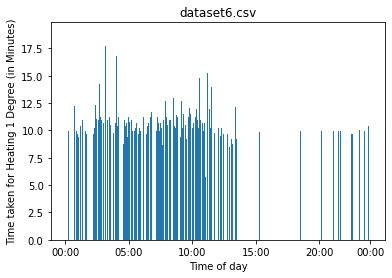

average time to Heating 2F:  18.26623111111111
Standard deviation  3.184160823724819


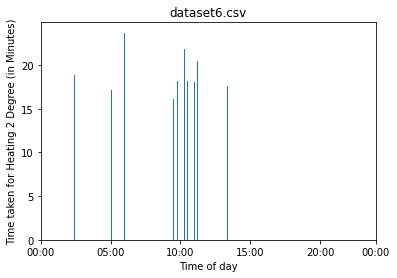

average time to Heating 3F:  23.97619
Standard deviation  3.184307623714211


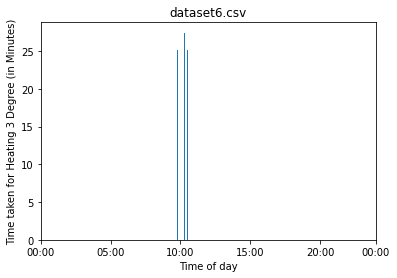

average time to Heating 4F:  32.21185
Standard deviation  1.385499354157326


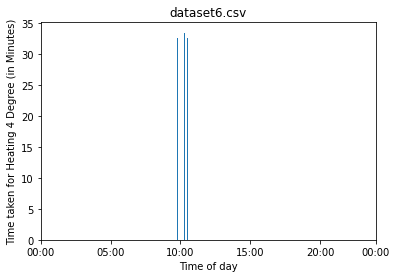

Average time to heat 1F  8.8914166049098
 standard deviation  1.1267357569175382


In [4]:
path = ''
pp = PdfPages ('./Plot' + str (n) + '.pdf')

for file_name in file_names:
    try:
      path = file_name
      dataset = pd.read_csv ((path))
    except:
      continue
    
    X = dataset.iloc[:, :]

    avg1 = time_to_change_temperature(X, 1)
    avg2 = time_to_change_temperature(X, 2)
    avg3 = time_to_change_temperature(X, 3)
    avg4 = time_to_change_temperature(X, 4)
    avg = (avg1 + avg2/2 + avg3/3 + avg4/4) / 4

    print('Average time to heat 1F ', avg)
    print(' standard deviation ', statistics.stdev([avg1, avg2/2, avg3/3, avg4/4]))

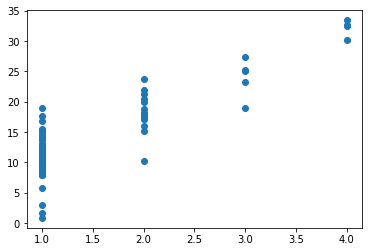

In [5]:
# pp.close ()
list = []
for arr in data:
    for elm in arr:
        list.append(elm)
df = pd.DataFrame(list)
plt.scatter(df['temp_change'], df['time'])

In [6]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(1, input_shape=(2,))) 
# # y = w1 * x1 + w2 * x2 + b
# # x1 = start temperature, x2 = temperature difference, y = time
# model.summary()

    
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense = tf.keras.layers.Dense(units=1, activation=None)

    def call(self, input_tensor, training=False):
        output = self.dense(input_tensor)
        return output
    
    def build_graph(self, input_shape):
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)
        if not hasattr(self, 'call'):
            raise AttributeError("User should define 'call' method in sub-class model!")
        
        _ = self.call(inputs)
        
    
model = MyModel()
model.build_graph((None,2))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [7]:
adam = tf.keras.optimizers.Adam(lr=0.03)
model.compile(optimizer=adam,
             loss='mse'
)

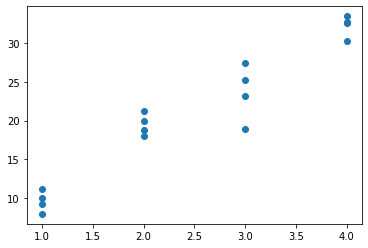

In [8]:
min_len = 10000;
for arr in data:
    if len(arr) < min_len:
        min_len = len(arr)

def data_generator(data):
    list = []
    for arr in data:
        list += random.sample(arr, min_len)

    df = pd.DataFrame(list)
    X = df.loc[:, ['start_temp', 'temp_change']]
    y = df['time']
    plt.scatter(df['temp_change'], df['time'])
    return X, y

X, y = data_generator(data)

Epoch 1/20
1/1 [==============================] - 1s 582ms/step - loss: 861.7988
Epoch 2/20
1/1 [==============================] - 0s 2ms/step - loss: 741.3505
Epoch 3/20
1/1 [==============================] - 0s 3ms/step - loss: 631.0767
Epoch 4/20
1/1 [==============================] - 0s 2ms/step - loss: 531.1168
Epoch 5/20
1/1 [==============================] - 0s 2ms/step - loss: 441.5499
Epoch 6/20
1/1 [==============================] - 0s 3ms/step - loss: 362.3772
Epoch 7/20
1/1 [==============================] - 0s 3ms/step - loss: 293.5121
Epoch 8/20
1/1 [==============================] - 0s 3ms/step - loss: 234.7661
Epoch 9/20
1/1 [==============================] - 0s 2ms/step - loss: 185.8342
Epoch 10/20
1/1 [==============================] - 0s 2ms/step - loss: 146.2847
Epoch 11/20
1/1 [==============================] - 0s 2ms/step - loss: 115.5506
Epoch 12/20
1/1 [==============================] - 0s 3ms/step - loss: 92.9272
Epoch 13/20
1/1 [==============================]

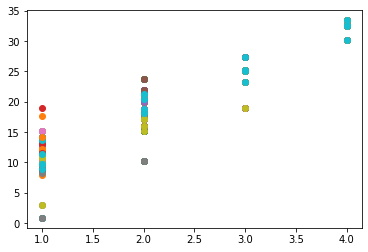

In [9]:
for i in range(100):
    X, y = data_generator(data)
    history = model.fit(X, y, epochs=20)

In [10]:
model.predict([[70, 1]])

array([[11.0282955]], dtype=float32)

In [11]:
model.predict(X)

array([[11.102741],
       [11.139964],
       [11.139964],
       [11.065517],
       [18.303946],
       [18.415615],
       [18.452837],
       [18.49006 ],
       [25.542374],
       [25.61682 ],
       [25.61682 ],
       [25.654043],
       [32.96692 ],
       [32.855247],
       [32.929695],
       [32.929695]], dtype=float32)

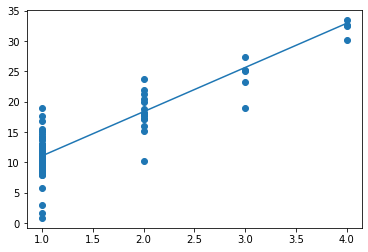

In [12]:
input = pd.concat([X.head(1), X.tail(1)])
output = pd.concat([y.head(1), y.tail(1)])
plt.scatter(df['temp_change'], df['time'])
plt.plot(input['temp_change'], model.predict(input))
plt.show()

In [13]:
# tf.saved_model.save(model, "mymodel")
model.save("mymodel")

INFO:tensorflow:Assets written to: mymodel\assets
